In [12]:
!git clone https://github.com/shreyas-bk/U-2-Net
    
import sys
sys.path.append('./U-2-Net')
from data_loader import RescaleT
from data_loader import ToTensor
from data_loader import ToTensorLab
from data_loader import SalObjDataset
from model import U2NET 
from model import U2NETP 

from IPython.display import display
from PIL import Image as Img

from torchvision import transforms
from torch.utils.data import Dataset, DataLoader
from torch.autograd import Variable
import numpy as np

fatal: destination path 'U-2-Net' already exists and is not an empty directory.


In [13]:
THRESHOLD = 0.3
def normPRED(d):
    ma = torch.max(d)
    mi = torch.min(d)
    dn = (d-mi)/(ma-mi)
    return dn


def pred_unet(model, imgs):
    
    test_salobj_dataset = SalObjDataset(img_name_list = imgs, lbl_name_list = [], transform = transforms.Compose([RescaleT(320),ToTensorLab(flag=0)]))
    test_salobj_dataloader = DataLoader(test_salobj_dataset, batch_size=1, shuffle=False, num_workers = 1)
    
    for i_test, data_test in enumerate(test_salobj_dataloader):
        
        inputs_test = data_test['image']
        print("inputs_test", inputs_test.shape)
        inputs_test = inputs_test.type(torch.FloatTensor)

        if torch.cuda.is_available():
            inputs_test = Variable(inputs_test.cuda())
        else:
            inputs_test = Variable(inputs_test)

        d1, d2, d3, d4, d5, d6, d7 = net(inputs_test)

        predict = d5[:,0,:,:]
        predict = normPRED(predict)
        
        del d1, d2, d3, d4, d5, d6, d7

        predict = predict.squeeze()
        predict_np = predict.cpu().data.numpy()

        # Masked image - using threshold you can soften/sharpen mask boundaries
        predict_np[predict_np > THRESHOLD] = 1
        predict_np[predict_np <= THRESHOLD] = 0
        mask = Img.fromarray(predict_np*255).convert('RGB')
        image = Img.open(imgs[0])
        imask = mask.resize((image.width, image.height), resample=Img.BILINEAR)
        back = Img.new("RGB", (image.width, image.height), (255, 255, 255))
        mask = imask.convert('L')
        im_out = Img.composite(image, back, mask)
        
        # Sailient mask 
        salient_mask = np.array(image)
        mask_layer = np.array(imask)        
        mask_layer[mask_layer == 255] = 50 # offest on RED channel
        salient_mask[:,:,0] += mask_layer[:,:, 0]
        salient_mask = np.clip(salient_mask, 0, 255) 
    
    return np.array(im_out), np.array(image), np.array(salient_mask), np.array(mask)

UNET2_SMALL = False

In [14]:
%%capture
import torch
if UNET2_SMALL:
    model_dir = "./U-2-Net/u2netp.pth"  # Faster ... a lot (!) but less accurate
    net = U2NETP(3,1) 
else:
    model_dir = "/home/zubair/Downloads/u2net.pth"
    net = U2NET(3,1) 


if torch.cuda.is_available():
    net.load_state_dict(torch.load(model_dir))
    net.cuda()
else:        
    net.load_state_dict(torch.load(model_dir, map_location=torch.device('cpu')))

net.eval()

inputs_test torch.Size([1, 3, 320, 320])
[[0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]
 ...
 [0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]]
(160, 120)


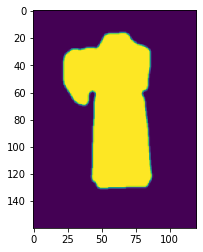

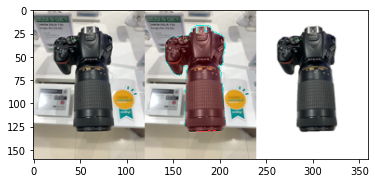

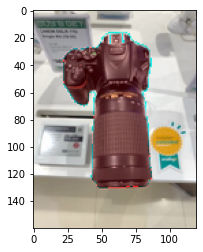

In [45]:
import matplotlib.pyplot as plt
import cv2
import os
import colorsys

def random_colors(N, bright=True):
    """
    Generate random colors.
    To get visually distinct colors, generate them in HSV space then
    convert to RGB.
    """
    brightness = 1.0 if bright else 0.7
    hsv = [(i / N, 1, brightness) for i in range(N)]
    colors = list(map(lambda c: colorsys.hsv_to_rgb(*c), hsv))
    # random.shuffle(colors)
    return colors

img = ['/home/zubair/nerf_pl/Objectron_data/camera_batch-2_1/images_12/00120.png']
image, im_oryg, sal_map, mask = pred_unet(net, img)

im = cv2.imread(img[0])

print(mask)
print(mask.shape)
plt.imshow(mask)
plt.show()
result = np.concatenate((im_oryg, sal_map, image), axis=1)
result_img = Img.fromarray(result)
plt.imshow(result_img)
plt.show()


seg_masks = mask.astype(np.uint8)
mask_save_dir = '/home/zubair/nerf_pl/Objectron_data/camera_batch-2_1'
seg_write_name = 'mask_'+'00120.png'
cv2.imwrite(os.path.join(mask_save_dir, seg_write_name), seg_masks)

def apply_mask(image, mask, color, alpha=0.5):
    """Apply the given mask to the image.
    """
    for c in range(3):
        image[:, :, c] = np.where(mask == 1,
                                  image[:, :, c] *
                                  (1 - alpha) + alpha * color[c],
                                  image[:, :, c])
    return image

colors = random_colors(mask.shape[0])
im = apply_mask(im, mask, colors[0])
plt.imshow(sal_map)
plt.show()

# axes[idx].axis('off')
# axes[idx].imshow(result_img)

# plt.subplots_adjust(wspace=0.05, hspace=0)
# plt.show()